In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random

from argparse import ArgumentParser
import datetime

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.backends.cudnn as cudnn

from pytvision.transforms import transforms as mtrans
from pytvision import visualization as view

sys.path.append('../')
from torchlib.datasets.datasets import ATLASDataset 
from torchlib.neuralnet import NeuralNetClassifier
from misc import get_transforms_det

from sklearn import metrics

In [2]:
pathname = os.path.expanduser( '~/.datasets' )
projectnet='../out/netruns'
no_cuda=False
seed=1
gpu=0
batch_size=60
workers=10
num_input_channels=3
parallel=False

print(pathname)
print(projectnet)

/home/fernandez/.datasets
../out/netruns


In [3]:
!ls ../out/netruns/

atlas_baseline_inception_v4_mix_adam_atlas_004
atlas_baseline_nasnetalarge_mix_adam_atlas_007
atlas_baseline_resnet18_mix_adam_atlas_005
atlas_baseline_resnet18_mix_adam_atlas_009
atlas_baseline_resnet34_mix_adam_atlas_011
atlas_baseline_resnet50_mix_adam_atlas_006
atlas_baseline_se_resnet50_mix_adam_atlas_011
results
resultsxxx
resultsxxxxx
test_atlas_baseline_inception_v4_mix_adam_atlas_004_atlas_0_dp.csv
test_atlas_baseline_inception_v4_mix_adam_atlas_004_atlas_1_dp.csv
test_atlas_baseline_inception_v4_mix_adam_atlas_004_atlas_2_dp.csv


In [4]:
name = 'atlas_baseline_se_resnet50_mix_adam_atlas_011'
project = os.path.join(projectnet, name)
model = 'model_best.pth.tar' #'chk000025.pth.tar', model_best
pathmodels = os.path.join(project,'models',model)

print(project)
print(pathmodels)

../out/netruns/atlas_baseline_se_resnet50_mix_adam_atlas_011
../out/netruns/atlas_baseline_se_resnet50_mix_adam_atlas_011/models/model_best.pth.tar


In [5]:
# neuralnet
network = NeuralNetClassifier(
    patchproject=project,
    nameproject=name,
    no_cuda=no_cuda,
    seed=seed,
    gpu=gpu,
    parallel=parallel,
    )

cudnn.benchmark = True

# load model
if network.load( pathmodels ) is not True:
    assert(False)

Without the incoming socket you cannot receive events from the server or register event handlers to your Visdom client.


=> loading checkpoint '../out/netruns/atlas_baseline_se_resnet50_mix_adam_atlas_011/models/model_best.pth.tar'
last_linear.weight dim model torch.Size([28, 2048]) vs dim checkpointtorch.Size([1000, 2048])
last_linear.bias dim model torch.Size([28]) vs dim checkpointtorch.Size([1000])
=> loaded checkpoint for se_resnet50 arch!


In [6]:
pathdata='~/.kaggle/competitions/human-protein-atlas-image-classification'
name_dataset='atlas'
subset='test'

data = ATLASDataset(        
    path=pathdata, 
    train=False,
    folders_images='test', 
    metadata='sample_submission.csv',
    #count=100,
    num_channels=3,
    transform=get_transforms_det( network.size_input ), #get_transforms_aug
    )

dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=workers )

print('Data loader ')
print(len(dataloader))
print(len(data))

Data loader 
196
11702


In [7]:
Id, Yhat, Y = network.predict( dataloader )

df = pd.DataFrame( np.concatenate((Id[:,np.newaxis], Yhat), axis=1) )
df.to_csv( os.path.join(project , '{}_{}_{}_dp.csv'.format(subset,name,name_dataset)), index=False, encoding='utf-8')        
print('dir: {}'.format(project))
print('DONE!!!')

100%|██████████| 196/196 [02:05<00:00,  1.56it/s]


dir: ../out/netruns/atlas_baseline_se_resnet50_mix_adam_atlas_011
DONE!!!


In [8]:
df = pd.read_csv( os.path.join(project , '{}_{}_{}_dp.csv'.format(subset, name, name_dataset))  )
df.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0.001421,4.540146e-05,0.999981,0.000006,0.000004,0.000043,0.000998,0.004131,1.938786e-10,...,0.000008,1.197568e-05,2.075234e-07,0.000257,0.000003,0.000119,4.329780e-08,0.000115,3.733942e-08,3.882363e-10
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0.098033,3.982864e-04,0.000425,0.000893,0.000797,0.996497,0.069883,0.001820,8.596804e-07,...,0.004831,8.973022e-04,2.626756e-06,0.005074,0.001143,0.000092,2.221282e-05,0.156430,7.992069e-07,5.498766e-07
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0.995254,1.370267e-07,0.000066,0.000124,0.000458,0.125050,0.000003,0.000048,4.885506e-12,...,0.000170,5.296101e-07,1.175238e-10,0.000006,0.000201,0.000005,2.871407e-11,0.999715,9.291911e-09,2.077145e-09
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0.999299,4.436498e-04,0.000185,0.000395,0.000973,0.005218,0.000013,0.000903,1.511913e-06,...,0.002134,4.182638e-04,5.957911e-06,0.000630,0.000620,0.000580,1.260791e-05,0.996745,8.261414e-05,1.369881e-05
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0.001989,8.320236e-05,0.004582,0.001299,0.001503,0.919757,0.059732,0.040169,2.441802e-05,...,0.001367,6.227934e-06,1.426526e-05,0.002347,0.007323,0.407269,3.590548e-05,0.997969,5.832600e-06,1.933623e-05


In [9]:
result = df.as_matrix()
iDs = result[:,0]
Yhat = result[:,1:]

print(iDs.shape)
print(Yhat.shape)


(11702,)
(11702, 28)


In [10]:
#th=0.1
(Yhat>0.1).sum(axis=0)

array([6102,  547, 1504,  626,  577, 1101,  488, 1148,    5,   15,    6,
        559,  385,  262,  664,    2,  225,  212,  535,  756,   59, 2534,
        407, 1226,  107, 5345,  143,    3])

(array([18.,  5.,  2.,  0.,  1.,  0.,  0.,  0.,  1.,  1.]),
 array([2.000e+00, 6.120e+02, 1.222e+03, 1.832e+03, 2.442e+03, 3.052e+03,
        3.662e+03, 4.272e+03, 4.882e+03, 5.492e+03, 6.102e+03]),
 <a list of 10 Patch objects>)

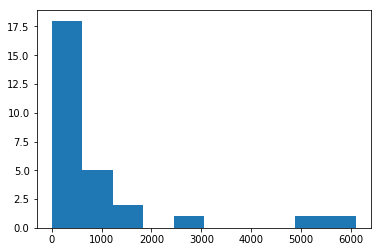

In [12]:
import matplotlib.pyplot as plt
plt.hist( (Yhat>0.1).sum(axis=0) )


In [84]:
pred = [ ' '.join( map(str,np.where( yhat > 0.4 )[0]) ) for yhat in  Yhat]
#code  = ' '.join( map(str, code) )
len(np.where( np.array([1,2,3]) < 0 )[0]) 

0

In [45]:
# submission_filepath = 'submission.csv'
# th=0.5
# #submission = [ {'Id': Id, 'Predicted': ' '.join( map(str, np.where( yhat > th )[0])  if len(np.where( yhat > th )[0])>0 else '0'  ) }  for (Id, yhat) in zip( iDs,Yhat) ]
# submission = [ {'Id': Id, 'Predicted': ' '.join( map(str, np.where( yhat > th )[0]) ) }  for (Id, yhat) in zip( iDs,Yhat) ]
# submission = pd.DataFrame( submission )
# submission.to_csv(submission_filepath, index=False, encoding='utf-8')
# print('SAVE!!!')
# submission


In [13]:

# ths = np.array( [2.53731637e-01, 2.46937891e-02, 7.13047930e-02, 3.07392383e-02,
#        3.65877673e-02, 4.94860384e-02, 1.98495530e-02, 5.55708716e-02,
#        1.04367689e-03, 8.86140759e-04, 5.51376472e-04, 2.15233744e-02,
#        1.35481076e-02, 1.05746131e-02, 2.09916900e-02, 4.13532354e-04,
#        1.04367689e-02, 4.13532354e-03, 1.77621992e-02, 2.91835690e-02,
#        3.38702690e-03, 7.43767477e-02, 1.57929975e-02, 5.83868300e-02,
#        6.34082943e-03, 1.62025915e-01, 6.45898153e-03, 2.16612185e-04])


# ths = np.array([0.2375, 0.0375, 0.0875, 0.0375, 0.0125, 0.0375, 0.025, 0.05625,
#        0.0, 0.0, 0.0, 0.025, 0.025, 0.0125, 0.025, 0.0, 0.01875, 0.00625,
#        0.025, 0.00625, 0.00625, 0.08125, 0.0125, 0.06875, 0.00625, 0.15,
#        0.0, 0.0])

ths = np.array( [0.362397820, 0.043841336, 0.075268817, 0.059322034, 0.075268817, 0.075268817, 0.043841336, 0.075268817, 0.0
                 , 0.0, 0.0, 0.043841336, 0.043841336, 0.014198783, 0.043841336, 0.0, 0.014198783, 0.014198783, 0.028806584, 
                 0.059322034, 0.0, 0.126126126, 0.028806584, 0.075268817, 0.0, 0.222493888, 0.028806584, 0.0  ])


In [15]:
submission_filepath = 'submission.csv'
th=0.2
submission = pd.read_csv('~/.kaggle/competitions/human-protein-atlas-image-classification/sample_submission.csv')

# submission_local = [ {'Id': Id, 'Predicted': ' '.join( map(str, np.where( yhat > th )[0])  if len(np.where( yhat > th )[0])>0 else '{}'.format( yhat.argmax() ) ) }  for (Id, yhat) in zip( iDs,Yhat) ]
submission_local = [ {'Id': Id, 'Predicted': ' '.join( map(str, np.where( yhat > th )[0]) ) }  for (Id, yhat) in zip( iDs,Yhat) ]
submission_local = pd.DataFrame( submission_local )
submission.loc[ submission['Id'] == submission_local['Id'], 'Predicted'] = submission_local['Predicted']
submission.to_csv(submission_filepath, index=False, encoding='utf-8')
submission


,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,5 23 25
5,00109f6a-bac8-11e8-b2b7-ac1f6b6435d0,4
6,001765de-bacd-11e8-b2b8-ac1f6b6435d0,4 23 25
7,0018641a-bac9-11e8-b2b8-ac1f6b6435d0,0 6 25
8,00200f22-bad7-11e8-b2b9-ac1f6b6435d0,0
9,0026f154-bac6-11e8-b2b7-ac1f6b6435d0,3 25


In [16]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f submission.csv -m "se_resnet50+mix+epoch50+ep02"

100%|█████████████████████████████████████████| 481k/481k [00:01<00:00, 344kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [13]:

f1 = pd.read_csv('~/.kaggle/competitions/human-protein-atlas-image-classification/sample_submission.csv')
f1.drop('Predicted', axis=1, inplace=True)
f2 = pd.read_csv('submission.csv')
f1 = f1.merge(f2, left_on='Id', right_on='Id', how='outer')
f1.to_csv('new_submission.csv', index=False)


In [ ]:
#!kaggle competitions submit -c human-protein-atlas-image-classification -f new_submission.csv -m "resnet18+mix+512x512+extern+sort"

In [24]:
submission = pd.read_csv('/root/.kaggle/competitions/human-protein-atlas-image-classification/sample_submission.csv')
submission

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0
5,00109f6a-bac8-11e8-b2b7-ac1f6b6435d0,0
6,001765de-bacd-11e8-b2b8-ac1f6b6435d0,0
7,0018641a-bac9-11e8-b2b8-ac1f6b6435d0,0
8,00200f22-bad7-11e8-b2b9-ac1f6b6435d0,0
9,0026f154-bac6-11e8-b2b7-ac1f6b6435d0,0


In [6]:
import pandas as pd
submission_df = pd.read_csv('submission_lb56.csv')
print(submission_df.head())

                                     Id Predicted
0  00008af0-bad0-11e8-b2b8-ac1f6b6435d0         2
1  0000a892-bacf-11e8-b2b8-ac1f6b6435d0         5
2  0006faa6-bac7-11e8-b2b7-ac1f6b6435d0    0 5 25
3  0008baca-bad7-11e8-b2b9-ac1f6b6435d0      0 25
4  000cce7e-bad4-11e8-b2b8-ac1f6b6435d0        25


In [7]:
submission_df.loc[submission_df['Id']=='a8d73536-bad8-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '0 23'
submission_df.loc[submission_df['Id']=='63ed01a4-bad7-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '14 16'
submission_df.loc[submission_df['Id']=='84c046b4-bad4-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '14 16'
submission_df.loc[submission_df['Id']=='69cbf89a-bace-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '0 16 25'
submission_df.loc[submission_df['Id']=='b9a882d6-bacc-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '14 16'
submission_df.loc[submission_df['Id']=='29d1d616-bacd-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '19'
submission_df.loc[submission_df['Id']=='f8f6566a-bac8-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '0 16'
submission_df.loc[submission_df['Id']=='9edb2498-bad8-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '16'
submission_df.loc[submission_df['Id']=='8dd19ca8-bacf-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '0 16 25'
submission_df.loc[submission_df['Id']=='adfa9e8e-bac6-11e8-b2b7-ac1f6b6435d0', 'Predicted'] = '5'
submission_df.loc[submission_df['Id']=='da5b852e-bacb-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '3'
submission_df.loc[submission_df['Id']=='df8d2780-bac8-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '16 25'
submission_df.loc[submission_df['Id']=='72a6fbf8-bad4-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '16 25'
submission_df.loc[submission_df['Id']=='f6b06252-bad6-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '0 16 25'
submission_df.loc[submission_df['Id']=='edb5b41e-bad0-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '0 16'
submission_df.loc[submission_df['Id']=='0a96bf2c-bad3-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '4'
submission_df.loc[submission_df['Id']=='1f97ea4a-bad3-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '0 25'
submission_df.loc[submission_df['Id']=='2327a292-bac7-11e8-b2b7-ac1f6b6435d0', 'Predicted'] = '5 16'
submission_df.loc[submission_df['Id']=='10d4730a-bada-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '0 16'
submission_df.loc[submission_df['Id']=='0b651912-bad3-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '16 25'
submission_df.loc[submission_df['Id']=='12dea42a-bacd-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '0 16 17 18'
submission_df.loc[submission_df['Id']=='b43493dc-bac5-11e8-b2b7-ac1f6b6435d0', 'Predicted'] = '2 11'
submission_df.loc[submission_df['Id']=='ba6febf2-bad4-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '16 25'
submission_df.loc[submission_df['Id']=='58148166-bacf-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '14 16'
submission_df.loc[submission_df['Id']=='79970da6-bac8-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '2 16'
submission_df.loc[submission_df['Id']=='c02bb81c-bac7-11e8-b2b7-ac1f6b6435d0', 'Predicted'] = '0 16 17 18'
submission_df.loc[submission_df['Id']=='fcd88d84-bad2-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '16 25'
submission_df.loc[submission_df['Id']=='59604078-bad9-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '16'
submission_df.loc[submission_df['Id']=='89b31fae-bad2-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '0 16'
submission_df.loc[submission_df['Id']=='88b38a80-bac8-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '2 16'
submission_df.loc[submission_df['Id']=='adc182fa-bad2-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '0 21'
submission_df.loc[submission_df['Id']=='6a322caa-bad3-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '5'
submission_df.loc[submission_df['Id']=='869a7f8c-bac9-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '0 5'
submission_df.loc[submission_df['Id']=='b478cc78-bad4-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '0 16'
submission_df.loc[submission_df['Id']=='e0f9483a-bacb-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '0 7'
submission_df.loc[submission_df['Id']=='9eafcf6a-bacd-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '0 21'
submission_df.loc[submission_df['Id']=='b7ae02d8-bac9-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '16 17 23'
submission_df.loc[submission_df['Id']=='dbdcd95c-bac6-11e8-b2b7-ac1f6b6435d0', 'Predicted'] = '5'
submission_df.loc[submission_df['Id']=='e7f56384-bad1-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '1'
submission_df.loc[submission_df['Id']=='43357408-bad9-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '17 25'
submission_df.loc[submission_df['Id']=='c5deab72-bad9-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '0 21'
submission_df.loc[submission_df['Id']=='b9acf08a-bac9-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '0 16'
submission_df.loc[submission_df['Id']=='e8bae166-bad8-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '2 17'
submission_df.loc[submission_df['Id']=='5661665e-bacf-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '17 25'
submission_df.loc[submission_df['Id']=='9e6fe8be-bad2-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '4'
submission_df.loc[submission_df['Id']=='df533cce-bac7-11e8-b2b7-ac1f6b6435d0', 'Predicted'] = '17'
submission_df.loc[submission_df['Id']=='7c1f771c-bac7-11e8-b2b7-ac1f6b6435d0', 'Predicted'] = '25'
submission_df.loc[submission_df['Id']=='f8cd7738-bad0-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '25'
submission_df.loc[submission_df['Id']=='39508fe6-bad3-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '0 16'
submission_df.loc[submission_df['Id']=='a56d3f98-bacf-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '9 10'
submission_df.loc[submission_df['Id']=='28601ba0-bac6-11e8-b2b7-ac1f6b6435d0', 'Predicted'] = '14'
submission_df.loc[submission_df['Id']=='8617f44e-baca-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '0'
submission_df.loc[submission_df['Id']=='1144d38e-bacb-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '21 16'
submission_df.loc[submission_df['Id']=='201229ac-bad0-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '2'
submission_df.loc[submission_df['Id']=='0f3274c0-bada-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '13'
submission_df.loc[submission_df['Id']=='29414644-bad4-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '4 21 26'
submission_df.loc[submission_df['Id']=='92c7e608-bad5-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '25'
submission_df.loc[submission_df['Id']=='83509894-bad2-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '13'
submission_df.loc[submission_df['Id']=='af2c5f2e-bac9-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '25'
submission_df.loc[submission_df['Id']=='bf6c33d0-bad5-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '4'
submission_df.loc[submission_df['Id']=='9da67d5c-bac9-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '14'
submission_df.loc[submission_df['Id']=='cbfe766e-bace-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '14'
submission_df.loc[submission_df['Id']=='c1dc11c4-bacd-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '0'
submission_df.loc[submission_df['Id']=='8f257b9c-bacf-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '21'
submission_df.loc[submission_df['Id']=='d69acc70-bac5-11e8-b2b7-ac1f6b6435d0', 'Predicted'] = '0'
submission_df.loc[submission_df['Id']=='94205e64-baca-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '16'
submission_df.loc[submission_df['Id']=='55eb4db6-baca-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '22 16 25'
submission_df.loc[submission_df['Id']=='10e592a2-bac6-11e8-b2b7-ac1f6b6435d0', 'Predicted'] = '21 16 19 25'
submission_df.loc[submission_df['Id']=='e7a05526-bad4-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '9 10'
submission_df.loc[submission_df['Id']=='896007d6-bad9-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '14 16'
submission_df.loc[submission_df['Id']=='111f3934-bad6-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '16 25'
submission_df.loc[submission_df['Id']=='aec4415e-bad9-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '2 16'
submission_df.loc[submission_df['Id']=='03f31e24-badb-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '16'
submission_df.loc[submission_df['Id']=='f60586ac-bac7-11e8-b2b7-ac1f6b6435d0', 'Predicted'] = '7 17'
submission_df.loc[submission_df['Id']=='fce301c8-bac9-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '5'
submission_df.loc[submission_df['Id']=='10748996-baca-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '15 25'
submission_df.loc[submission_df['Id']=='2367dd2c-bac6-11e8-b2b7-ac1f6b6435d0', 'Predicted'] = '21 11 16'
submission_df.loc[submission_df['Id']=='9d2d08b2-bada-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '12'
submission_df.loc[submission_df['Id']=='260a351a-bac7-11e8-b2b7-ac1f6b6435d0', 'Predicted'] = '17'
submission_df.loc[submission_df['Id']=='54138f64-bad7-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '17 25'
submission_df.loc[submission_df['Id']=='443b81cc-bac9-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '15'
submission_df.loc[submission_df['Id']=='72c9bb82-bac7-11e8-b2b7-ac1f6b6435d0', 'Predicted'] = '4 21 17'
submission_df.loc[submission_df['Id']=='be0cf5a8-bad3-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '16 23'
submission_df.loc[submission_df['Id']=='01835f6c-bad3-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '4'
submission_df.loc[submission_df['Id']=='74993d6e-bad8-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '16'
submission_df.loc[submission_df['Id']=='84ca8928-bad2-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '17'
submission_df.loc[submission_df['Id']=='8f8c19a6-bacf-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '0 25'
submission_df.loc[submission_df['Id']=='107d6830-bac6-11e8-b2b7-ac1f6b6435d0', 'Predicted'] = '0 19 25'
submission_df.loc[submission_df['Id']=='70f3e586-bacb-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '0 21'
submission_df.loc[submission_df['Id']=='a7e9e53a-bad1-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '16 25'
submission_df.loc[submission_df['Id']=='aa45019c-bad2-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '0 16'
submission_df.loc[submission_df['Id']=='4509520a-bad3-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '1 2'
submission_df.loc[submission_df['Id']=='ec087d1e-bacf-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '0 16 25'
submission_df.loc[submission_df['Id']=='18d295a6-bad9-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '23'
submission_df.loc[submission_df['Id']=='db77c3dc-bacb-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '17 19'
submission_df.loc[submission_df['Id']=='a6c830fa-bad9-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '22'
submission_df.loc[submission_df['Id']=='0457b426-baca-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '2'
submission_df.loc[submission_df['Id']=='d79a1e12-bad1-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '16'
submission_df.loc[submission_df['Id']=='7929949a-bad4-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '17 25'
submission_df.loc[submission_df['Id']=='7d7565e2-bad9-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '0 16'
submission_df.loc[submission_df['Id']=='d6a07ae2-bad1-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '5'
submission_df.loc[submission_df['Id']=='82c1d5f6-bacc-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '0 14 18'
submission_df.loc[submission_df['Id']=='bfdfc644-bac9-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '19'
submission_df.loc[submission_df['Id']=='74bdbb12-bace-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '7 25'
submission_df.loc[submission_df['Id']=='a4b77124-bad7-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '23'
submission_df.loc[submission_df['Id']=='27ca9b0e-bace-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '12'
submission_df.loc[submission_df['Id']=='9ded793a-bacb-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '2 4'
submission_df.loc[submission_df['Id']=='77161884-bad6-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '16'
submission_df.loc[submission_df['Id']=='17d8a71c-bacf-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '5'
submission_df.loc[submission_df['Id']=='c3c67272-bad7-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '0'
submission_df.loc[submission_df['Id']=='b52035ba-bad1-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '3'
submission_df.loc[submission_df['Id']=='718ebf3e-bada-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '16 17 23'
submission_df.loc[submission_df['Id']=='530bfbea-baca-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '14 17 23'
submission_df.loc[submission_df['Id']=='c78652b6-bad6-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '0 25'
submission_df.loc[submission_df['Id']=='8316d286-bad6-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '6 21'
submission_df.loc[submission_df['Id']=='e1d58c82-bac6-11e8-b2b7-ac1f6b6435d0', 'Predicted'] = '0 16'
submission_df.loc[submission_df['Id']=='1a15e75a-bad5-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '0 16 17'
submission_df.loc[submission_df['Id']=='0f0ccc64-bad7-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '0 16 25'
submission_df.loc[submission_df['Id']=='b642cefc-bad7-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '0 16 25'
submission_df.loc[submission_df['Id']=='9f71c832-bacc-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '14 16'
submission_df.loc[submission_df['Id']=='f665e29c-bad4-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '14 16'
submission_df.loc[submission_df['Id']=='e75331f2-bad8-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '14 16'
submission_df.loc[submission_df['Id']=='be034880-bad0-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '14 16 19'
submission_df.loc[submission_df['Id']=='5d2711a6-bac9-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '14 16 25'
submission_df.loc[submission_df['Id']=='89975d50-bad7-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '15 25'
submission_df.loc[submission_df['Id']=='7fcba676-bad9-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '15 25'
print(submission_df.head())

                                     Id Predicted
0  00008af0-bad0-11e8-b2b8-ac1f6b6435d0         2
1  0000a892-bacf-11e8-b2b8-ac1f6b6435d0         5
2  0006faa6-bac7-11e8-b2b7-ac1f6b6435d0    0 5 25
3  0008baca-bad7-11e8-b2b9-ac1f6b6435d0      0 25
4  000cce7e-bad4-11e8-b2b8-ac1f6b6435d0        25


In [10]:
submission_filepath = 'submission.csv'
submission_df.to_csv(submission_filepath, index=False, encoding='utf-8')
print('save ...')

save ...


In [9]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f submission.csv -m "submissionlb56+leakhash"

100%|█████████████████████████████████████████| 476k/476k [00:00<00:00, 605kB/s]
Successfully submitted to Human Protein Atlas Image Classification